# Experiment Template <a class="tocSkip">

To use this template, please use the [file tree](./) to duplicate this notebook and move it to the folder of your repository. The following sections contain only exemplary content, please adapt and change based on your experiment implementation.

**In this notebook:**

* Describe your notbeook here in a few bullet points, e.g.:
* Method xyz on dataset abc --> Key insight: xyz works pretty well
* Modification zyx --> Dead end

**Todo:**

* List all todos that are related to this notebook here, e.g.:
* Apply xyz to another dataset

This could be some more general information on method xyz (e.g. a link to a paper).

_Please use a Python 3 kernel for the notebook_

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [1]:
# It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

!pip install -q -e ../utils/

### Import Dependencies

In [2]:
# System libraries
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git
import comet_ml

# Project utils
import aneurysm_utils
from aneurysm_utils import evaluation, training

/opt/conda/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Initialize Environment

In [3]:
env = aneurysm_utils.Environment(project="ML_in_MIP", root_folder="/workspace/")
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: ML_in_MIP

Folder Structure: 
- Root folder: /workspace
 - Project folder: /workspace/ML_in_MIP
 - Datasets folder: /workspace/ML_in_MIP/datasets
 - Models folder: /workspace/ML_in_MIP/models
 - Experiments folder: /workspace/ML_in_MIP/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [4]:
dataset_params = {
    "prediction": "mask",
    "mri_data_selection": "unprocessed", 
    "balance_data": False,
    "seed": 1
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
}

### Load Meta Data

In [5]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

,Aneurysm Geometry,Angiography Data,Vessel Geometry,Labeled Mask Index,Location,Age,Sex,Rupture Status,Age Bin,Aneurysm Count,Case,Path Orig,Path Mask,Path Vessel,Path Labeled Mask
0,A001.stl,A001_orig.nii.gz,A001_vessel.stl,1,Acom,48,m,1.0,"(40, 50]",1,A001,/workspace/ML_in_MIP/datasets/unprocessed/A001...,/workspace/ML_in_MIP/datasets/unprocessed/A001...,/workspace/ML_in_MIP/datasets/unprocessed/A001...,/workspace/ML_in_MIP/datasets/unprocessed/A001...
1,A003.stl,A003_orig.nii.gz,A003_vessel.stl,1,Pcom,58,f,0.0,"(50, 60]",1,A003,/workspace/ML_in_MIP/datasets/unprocessed/A003...,/workspace/ML_in_MIP/datasets/unprocessed/A003...,/workspace/ML_in_MIP/datasets/unprocessed/A003...,/workspace/ML_in_MIP/datasets/unprocessed/A003...
2,A005.stl,A005_orig.nii.gz,A005_vessel.stl,1,PICA,45,m,1.0,"(40, 50]",1,A005,/workspace/ML_in_MIP/datasets/unprocessed/A005...,/workspace/ML_in_MIP/datasets/unprocessed/A005...,/workspace/ML_in_MIP/datasets/unprocessed/A005...,/workspace/ML_in_MIP/datasets/unprocessed/A005...
3,A006.stl,A006_orig.nii.gz,A006_vessel.stl,1,ACom,46,f,1.0,"(40, 50]",1,A006,/workspace/ML_in_MIP/datasets/unprocessed/A006...,/workspace/ML_in_MIP/datasets/unprocessed/A006...,/workspace/ML_in_MIP/datasets/unprocessed/A006...,/workspace/ML_in_MIP/datasets/unprocessed/A006...
4,A008.stl,A008_orig.nii.gz,A008_vessel.stl,1,ACA,72,f,0.0,"(70, 80]",1,A008,/workspace/ML_in_MIP/datasets/unprocessed/A008...,/workspace/ML_in_MIP/datasets/unprocessed/A008...,/workspace/ML_in_MIP/datasets/unprocessed/A008...,/workspace/ML_in_MIP/datasets/unprocessed/A008...


### Load & Split MRI Data

In [6]:
# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
case_list = ["A001", "A130_R", "A005"]
df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"]
)

mri_imgs_train, labels_train = train_data
mri_imgs_test, labels_test = test_data
mri_imgs_val, labels_val = val_data

         Images
-----  --------
All           3
Train         1
Val           1
Test          1



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
from aneurysm_utils import preprocessing

preprocessing.check_mri_shapes(mri_imgs_train)

Most common:
(256, 256, 220):       1


## Transform & Preprocess Data

In [8]:
from aneurysm_utils import preprocessing

size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)

mri_imgs_train = mri_imgs[:size_of_train]
mri_imgs_train = [train[30:220,30:220,120:128] for train in mri_imgs_train]
mri_imgs_test = mri_imgs[size_of_train : size_of_train + size_of_test]
mri_imgs_test = [test[30:220,30:220,120:128] for test in mri_imgs_test]
mri_imgs_val = mri_imgs[size_of_train + size_of_test :]
mri_imgs_val = [val[30:220,30:220,120:128] for val in mri_imgs_val]

# preprocess mask
x, y, h = labels_train[0][30:220,30:220,120:128].shape
labels_train = [label_train[30:220,30:220,120:128] for label_train in labels_train]
labels_test = [label_test[30:220,30:220,120:128] for label_test in labels_test]
labels_val = [label_val[30:220,30:220,120:128] for label_val in labels_val]
# flatten

[INFO] Preprocessing: Min Max Normalize...


In [9]:
mri_imgs_train[0].shape

(190, 190, 8)

In [10]:
labels_train[0].shape

(190, 190, 8)

### Optional: View image



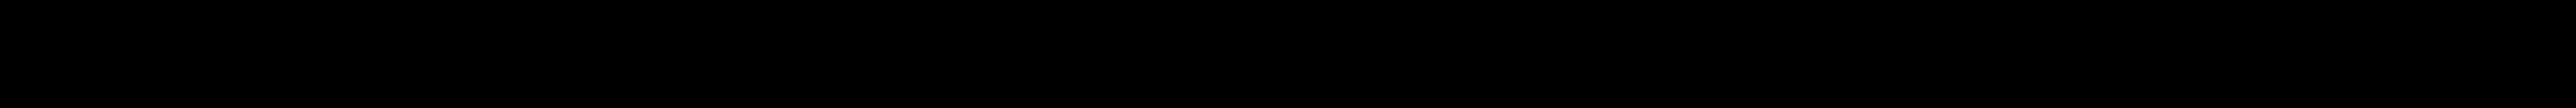
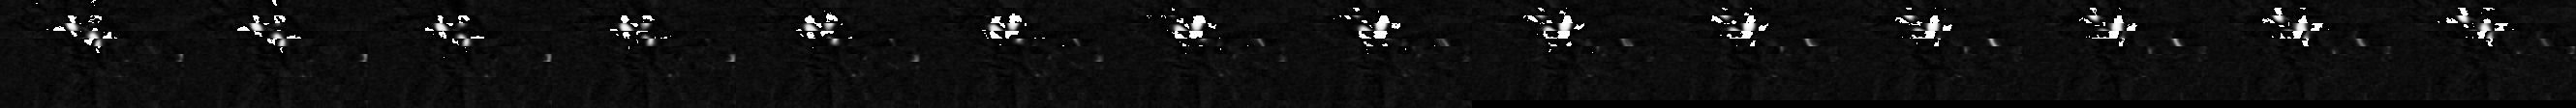

In [11]:
idx = 0
nip.view_img(
    nib.Nifti1Image(mri_imgs_train[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [12]:
evaluation.plot_slices(mri_imgs_train[0])


0.0 0.8809088 None None


## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [13]:
artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

# Define parameter configuration for experiment run
params = {
    # "seed": 1, moved to dataset params
    "training_size": None,  # None=all
    "val_size": None,   # None=all
    "batch_size": 3,
    "epochs": 1,
    "learning_rate": 5.0e-5, # 3e-04, 1.0E-5
    "es_patience": 75, # None = deactivate early stopping
    "weight_decay": 0.001, # 1e-3
    "model_name": '3DUnet', # "resnet", "preresnet", "wideresnet", "densenet", "simpleCNN", "ClassificationModel3D", "CNN3DSoftmax", "CNN3DMoboehle", "CNN3DTutorial", "LinearModel3D",
    #"model_depth": 10, # 10
    #"resnet_shortcut": 'B',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": 'BCEDiceLoss',
    "criterion_weights": False, # [1.75, 1.0],
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "scheduler": None, # "ReduceLROnPlateau",
    "save_models": False,
    "debug": True,
    "dropout": 0.4,
    "dropout2": 0.2
    #"pretrain_path": env.get_file("models/resnet_10_23dataset.pth"),
    #"train_pretrain": True,
    #"new_layer_name": ["fc"]
}

params.update(dataset_params)
params.update(preprocessing_params)

# data augmentation
# use dropout
# Cross-validation

In [14]:
# Run experiment and sync all metadata
exp = env.create_experiment(
    params["prediction"] + "-pytorch-" + params["model_name"],
    comet_ml.Experiment(
        env.cached_data["comet_key"],
        project_name=env.project + "-" + params["prediction"],
        disabled=params["debug"],
    ),
)
exp.run(training.train_pytorch_model, params, artifacts)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


[INFO] Experiment mask-pytorch-3DUnet is initialized.
[INFO] Running experiment: 2021-05-30-00-15-57_mask-pytorch-3dunet
 190
Selected model: UNet3D
[INFO] Train dataset loaded. Length: 1
[INFO] Validation dataset loaded. Length: 1
[INFO] Engine run starting with max_epochs=1.
torch.Size([1, 1, 190, 190, 8])
[ERROR] Current run is terminating due to exception: 'BCEDiceLoss' object has no attribute 'target'.
[ERROR] Engine run is terminating due to exception: 'BCEDiceLoss' object has no attribute 'target'.
[INFO] Experiment run failed: mask-pytorch-3DUnet. Duration: 3 seconds


ModuleAttributeError: 'BCEDiceLoss' object has no attribute 'target'

## Evaluate Model

In [ ]:
# Do evaluation, e.g. visualizations  